In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
import matplotlib.colors as colors
import matplotlib.animation as animation
import matplotlib.ticker as mtick
from IPython.display import set_matplotlib_formats, HTML
set_matplotlib_formats('png', 'pdf')
plt.rcParams['figure.dpi'] = 100

In [3]:
import numpy as np
import scipy.special as spec
import scipy.integrate as inte
import sympy as sp
sp.init_printing()

In [4]:
# Variables mathématiques

r, omega = sp.symbols('r omega', positive = True) # Distance et fréquence
t = sp.symbols('t', real=True) # Temps
Ic = sp.symbols('I', complex=True) # Courant électrique

mu = sp.symbols("mu0", positive = True) # Perméabilité magnétique du vide
c = sp.symbols("c", positive=True)      # Célérité de la lumière dans le vide
k = omega/c                             # relation de dispersion

# Position du problème

Étant donné un fil électrique très long parcouru par un courant électrique $i$, on cherche à déterminer le champ magnétique créé par phénomène d'induction dans l'espace autour. On peut le détecter en approchant une boussole, de la limaille de fer ou d'autres aimants permanents du fil, voire approcher un autre fil électrique lui aussi parcouru par un courant.

# Implémentations en Python du champ magnétique et du courant électrique

Dans tout ce document, le courant et le champ magnétique seront représentés par des instances des classes `current` et `magField`, qui sont définies dans cette section. 

Chaque courant, par exemple, sera un objet de type `current`, dont les attributs, tels que `frequences`, `intensites`, `expr`, `func` contiendront les caractéristiques du courant, son expression mathématique, et une fonction numérique permettant de le calculer.

## Champ magnétique : classe `magField`

In [5]:
# Composante du potentiel vecteur associée à la pulsation omega
A_component = -mu*Ic/4* \
    (sp.bessely(0,k*r) + sp.I*sp.besselj(0,k*r))*sp.exp(sp.I*omega*t)

# Composante du champ magnétique associée à la pulsation omega
B_component = - sp.diff(A_component, r).simplify()

In [6]:
B_component

La cellule suivante définit les champs magnétiques comme une classe Python `magField`, dont les attributs sont notamment l'expression formelle du champ (`expr`), et la fonction numérique qui permet de calculer le champ en un point (`func`).

(**Attention code long**)

In [7]:
class magField:
    
    def bake_field(self, intens):
        '''
        Construit le champ magnétique
        '''
        c0 = self.cel
        mu0_v = 4e-7*np.pi
        
        spectr = zip(intens,self.pulsations)
        
        B_expr = sum([B_component.subs({Ic: cur, omega:om, c:c0, mu:mu0_v}) \
                for (cur,om) in spectr if (cur!=0 and om!=0)])
        B_expr_re = sp.re(B_expr)
        B_function = sp.lambdify((r, t), B_expr_re, 
            modules=['numpy',{"besselj":spec.jn, "bessely":spec.yn}])
        
        self.expr = B_expr_re
        self.func = B_function
    
    def __init__(self, intens, puls, phas=None):
        
        self.cel = 3e8 # Célérité des ondes ; à modifier en fonction du milieu
        
        if phas is None:
            intens = np.asarray(intens)*np.exp(1j*np.asarray(phas))
        
        self.pulsations = puls
        self.frequences = puls/(2*np.pi)
        self.wavenumbers = self.pulsations/self.cel
        
        self.bake_field(intens)
        
    def draw(self, times, ani = False, custTitl = None):
        '''
        Construit les graphes du champ magnétique B aux temps donnés dans la liste
        "times"
        Si le drapeau 'ani' est True, alors entrer en mode "animation"
        '''
        func = self.func
        
        radii = np.linspace(rmin, rmax, 1000)

        fig = plt.figure(1, figsize=(8,5))
        ax = plt.axes()
        ax.set_xlim((rmin,rmax))
        ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))

        # Donne la légende 'temps'
        def legende(ti):
            out = r'$t= {:.3e}$'.format(ti)
            out = out + r"$\ \mathrm{s}$"
            return out

        if not(ani):
            if hasattr(times, '__iter__'):
                for ti in times:
                    champ = func(radii, ti)
                    ax.plot(radii, champ, label=legende(ti))
            else:
                champ = func(radii, times)
                ax.plot(radii, champ, label=legende(times))
            ax.legend(loc='best')
        else:
            line, = ax.plot([], [], lw=2)
            time_text = ax.text(0.02, 0.95, '', 
                                transform=ax.transAxes)


            t0, t1= times
            interval = t1 - t0
            animtime = 15
            fps = 30
            dt = interval/animtime # secondes vidéo par seconde réelle
            framenum = int(np.ceil(fps*animtime))

            ymax = func(radii,t0).max()

            ax.set_ylim((-1.3*ymax,1.3*ymax))

            def init():
                line.set_data([],[])
                time_text.set_text('')
                return line, time_text

            def animate(i):
                ti = dt*i/fps+t0
                legende_temps = legende(ti)
                champ = func(radii, ti)
                line.set_data(radii, champ)
                time_text.set_text(legende_temps)
                return line, time_text

        ax.grid(True)
        ax.set_xlabel("Distance $r$ (m)")
        ax.set_ylabel("Valeur du champ (T)")
        if custTitl:
            ax.set_title(custTitl)
        else:
            ax.set_title(r'Champ magnétique ' + r'$\mathbf{B}$' \
                         + ' créé par un courant variable')


        fig.tight_layout()

        if ani:
            anima = animation.FuncAnimation(fig, animate, init_func=init,
                        frames = framenum, interval = interval, blit = True)
            mywriter = animation.FFMpegWriter(fps=fps, bitrate=1000)
            self.writer = mywriter
            fig.tight_layout()
            self.animation = anima
        else:
            self.graphe = fig
            
    def make_portrait(self, t, colmap='bone'):
        """
        Portrait du champ magnétique à l'instant t
        """
        wind = rmax

        func = self.func

        def field_func(x,y):
            r = np.sqrt(x*x+y*y)
            Btheta = func(r, t)
            direct = np.array([-y/r, x/r])
            return Btheta*direct

        Y, X = np.ogrid[-wind:wind:1000j, -wind:wind:1000j]
        BX, BY = field_func(X, Y)
        intensity = np.sqrt(BX**2+BY**2)


        fig, ax = plt.subplots(1, 1, figsize=(8,8))

        heat = ax.imshow(intensity, 
                         cmap=colmap,
                         norm=colors.LogNorm(), 
                         extent=[-wind, wind, -wind, wind], 
                         alpha=0.6)
        cbar = fig.colorbar(heat,
                    label='Intensité du champ (T)')

        strm = ax.streamplot(X,Y, BX, BY, 
            arrowstyle='->', 
            color='w',
            linewidth=0.8,
            arrowsize=2,
            density=1.4,
            )

        ax.grid(False)
        ax.set_aspect('equal')
        ax.set_xlim((-wind,wind))
        ax.set_ylim((-wind,wind))
        title_text = r'Champ magnétique $\mathbf{B}$ à '
        title_text += r"$t={:g}$".format(t)
        title_text += r" $\mathrm{s}$"
        ax.set_title(title_text)
        fig.tight_layout()

        self.portrait = fig

On pourrait éventuellement implémenter une classe `elecField` représentant le courant électrique... Le lecteur intrépride pourra s'y aventurer en répliquant le schéma adopté plus haut, ou en faisant une sous-classe de `magField`.

In [8]:
# Composante du champ électrique associée à la pulsation omega
E_component = -sp.diff(A_component, t).expand().simplify()
E_component

## Courant électrique : classe `current`

Tout d'abord, l'expression d'une composante du champ associée à une pulsation $\omega$, et d'intensité $I$ :

In [9]:
# Composante du courant électrique de pulsation omega
cour_component = Ic*sp.exp(sp.I*omega*t)
cour_component

La cellule suivante définit les courants électriques comme une classe Python `magField`, dont les attributs sont notamment l'expression formelle du champ (`expr`), et la fonction numérique qui permet de calculer le courant à un instant (`func`).

In [10]:
class current:
    
    def bake_current(self, intens):
        """
        Calcule l'expression mathématique 'self.expr' et définit une fonction
        numérique 'self.func' permettant de calculer le courant à un instant.
        """
        spector = zip(intens,puls)
        cour = sum([cour_component.subs({Ic:i, omega:om}) \
                for i,om in spector ])
        cour_re = sp.re(cour)
        
        cour_func = sp.lambdify((t),cour_re,modules=['numpy'])
        
        self.expr = cour_re
        self.func = cour_func

    def __init__(self, intens, puls, phas=None):
        '''
        Étant donné le spectre (intensités et pulsations), initialise le courant
        en attribuant les fréquences/pulsations du courant, les intensités
        (complexes) associées. L'argument d'une intensité complexe correspond 
        au déphasage de la composante du courant associée.
        
        Si les phases sont précisées, elles sont ajoutées aux arguments des
        intensités.
        
        '''
        if phas is None:
            intens = np.asarray(intens)*np.exp(1j*np.asarray(phas))
        
        self.intensities = intens
        self.pulsations = puls
        self.frequences = self.pulsations/(2*np.pi)
        
        self.bake_current(intens)

    def draw(self, custTitle=None):
        """
        Construit la représentation graphique de la fonction i(t),
        stockée dans l'attribut 'self.graphe'
        
        custTitle : titre optionnel à fournir
        """
        
        
        func = self.func
        freqs = self.frequences
        
        tmax = 2/freqs.min()
        times = np.linspace(0, tmax, 1000)
        
        fig,ax=plt.subplots(1,1,figsize=(8,5))

        ax.grid(True)
        ax.plot(times, func(times))
        if custTitle:
            ax.set_title(custTitle)
        else:
            ax.set_title(r"Courant électrique dans le fil")
        fig.tight_layout()
        
        self.graphe = fig
    
    def draw_fft(self, discreet = True):
        fig, ax = plt.subplots(1,1,figsize=(8,5))
        puls = self.pulsations
        intens = self.intensities
        
        if discreet:
            xbins=range(0,len(puls))
            plt.hist(intens,bins=xbins)
        else:
            ax.plot(puls, np.abs(intens))
        

# Exemples d'utilisation

## Données initiales

Entrez dans la variable `freqs` les fréquences du courant voulu, et dans `phas` les phases associées, et exécutez la cellule (`Ctrl + Entrée` sur le clavier) pour définir la fonction de champ :

In [11]:
freqs = np.array([n*1e8 for n in range(5,7)] + \
    [n*1e5 for n in range(2,5)])

puls = 2*np.pi*np.asarray(freqs) # Pulsations associées
intens = np.array([2,3,1,4,1]) # Intensités des composantes

phases = np.array([0,0,0,0,0]) # Phases des composantes

B_field = magField(intens, puls, phases)

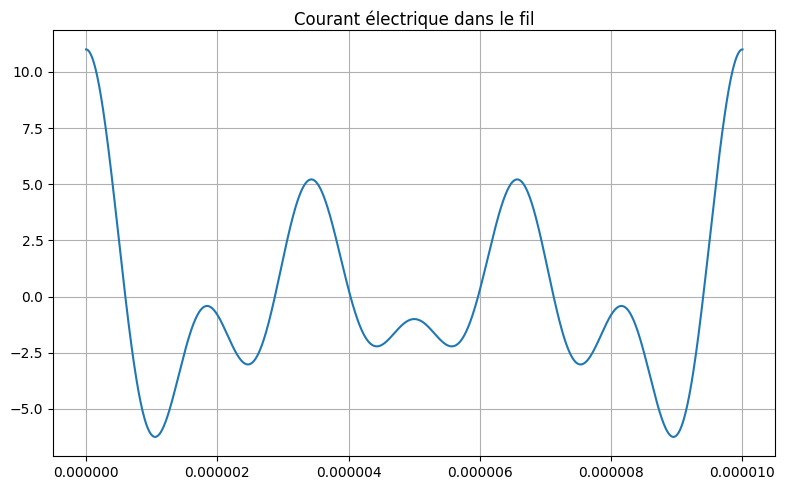

In [12]:
courant = current(intens, puls, phases)
courant.draw()

La cellule suivante définit les distances minimale et maximale pour lesquels tracer le profil du champ magnétique :

In [13]:
rmin = 0.03
rmax = 2

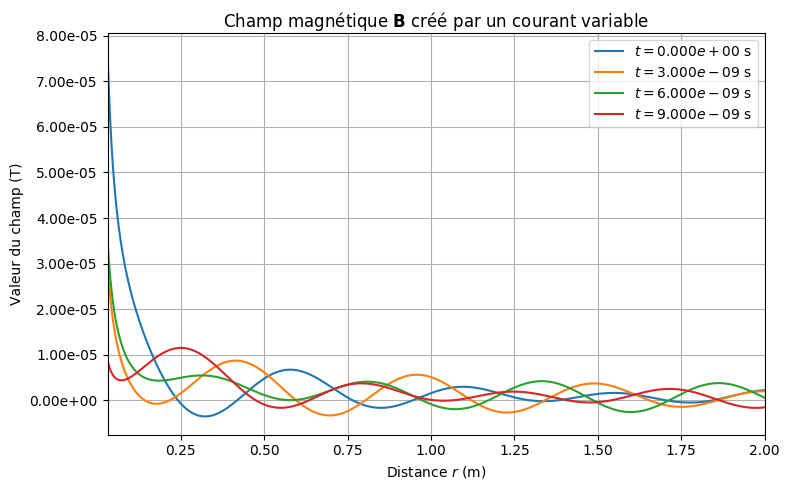

In [14]:
times = [1e-9*k for k in [0, 3, 6, 9]]

B_field.draw(times)

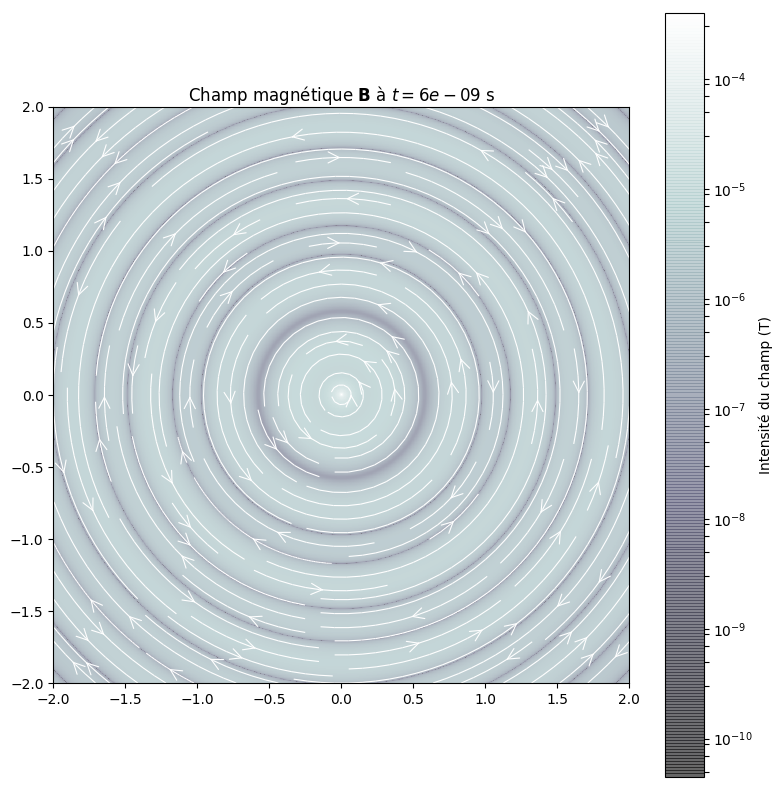

In [15]:
t_p = times[2]    # Temps auquel calculer le portrait du champ (pas de liste)

B_field.make_portrait(t_p)
B_field.portrait.savefig('portrait_champmag.pdf')
B_field.portrait.savefig('portrait_champmag.png')

## Animations

Modifiez cette cellule avec les fréquences que vous voulez utiliser pour les animations :

In [52]:
freqs = np.array([n*1e9 for n in [2,6,8,14,15]] + \
    [n*1e5 for n in range(2,5)]\
        )

puls = 2*np.pi*np.array(freqs) # Pulsations associées

intens = [1,1,1,1,1,7,10,10] # Intensités des composantes
phases = [-0.3,0,-0.4,-0.1,0.2,0.3] # Phases des composantes

B_field = magField(intens, puls, phases)

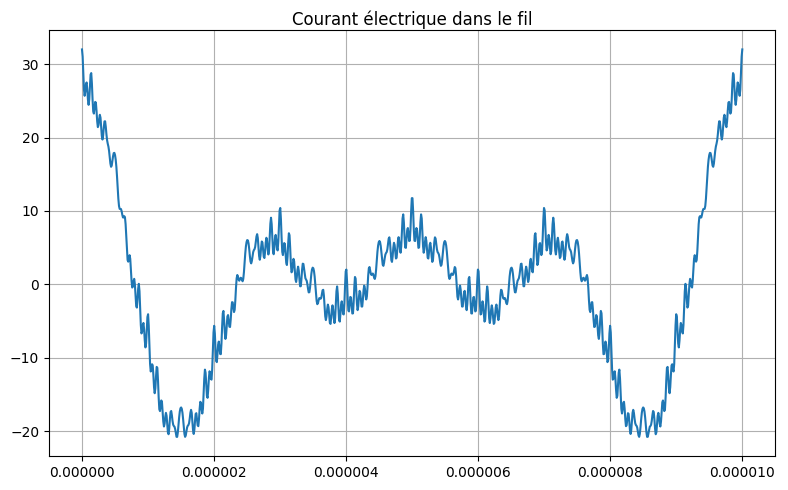

In [53]:
courant = current(intens,puls,phases)
courant.draw()

In [54]:
rmin = 0.05
rmax = 1

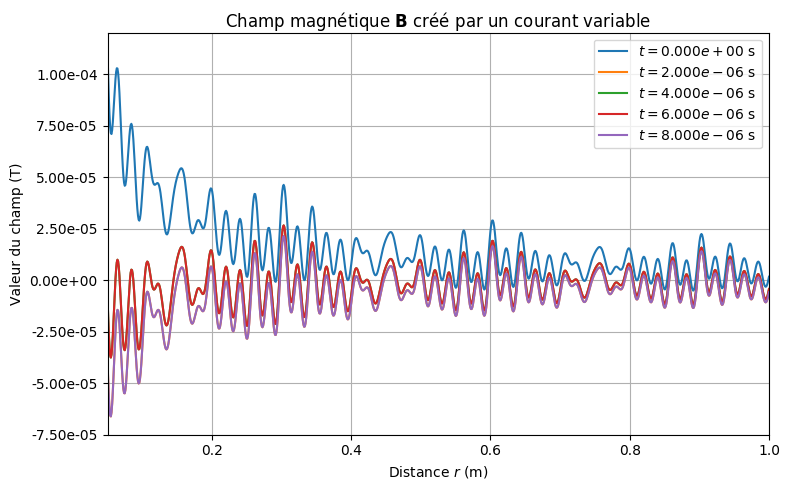

In [55]:
B_field.draw([1e-6*2*n for n in range(0,5)])

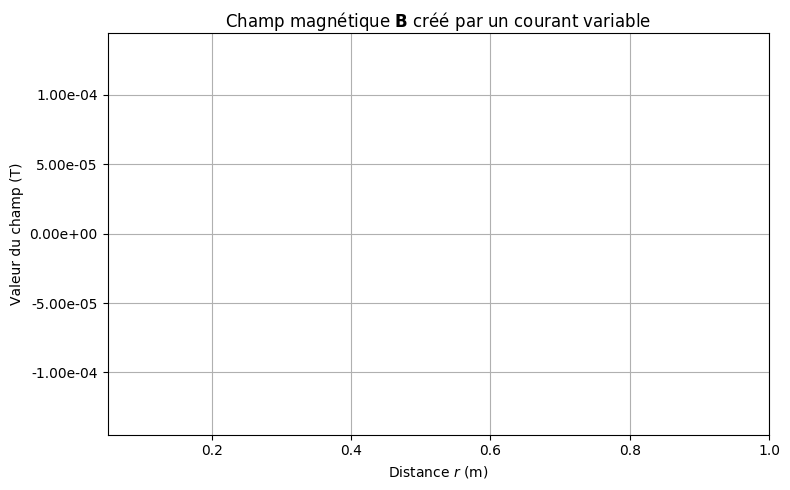

In [56]:
times_an = [0, 1e-5]

B_field.draw(times_an, True)

In [57]:
B_field.animation.save("champmag_anim.mp4", writer=B_field.writer)

# Paquet d'ondes

In [ ]:
def gaussienne(tau,t):
    tard = t - 0
    return np.exp(-tard**2/(2*tau**2))*np.sin(100*t/tau)

def draw_gaussienne(tau):
    T = np.linspace(-N/fs, N/fs, N+1)
    Y = gaussienne(tau, T)
    fig, ax = plt.subplots(1,1,figsize=(8,5))
    ax.grid(True)
    ax.plot(T, Y)
    ax.set_xlabel(r"Temps $t$ (s)")
    title = r"Paquet d'onde d'extension $\tau = {:.1e}$ ".format(tau) + r"$\mathrm{s}$"
    fig.suptitle(title)

In [ ]:
tau = 1e-12
N = 2**10 # Nombre d'échantillons
fs = 2**44 # Fréquence d'échantillonnage

In [ ]:
draw_gaussienne(tau)

In [ ]:
def fft_gauss(tau, fs, N):
    """
    N: nombre d'échantillons
    """
    dt = 1/fs # Pas
    
    sampled_time = np.linspace(-N*dt,N*dt,N+1)
    courant = gaussienne(tau, sampled_time)/np.sqrt(2*np.pi*tau)
    return courant

In [ ]:
courant = fft_gauss(tau, fs, N)

intens = np.fft.rfft(courant) # Intensités
puls = np.fft.rfftfreq(N, d=1/fs)     # Pulsations associées

In [ ]:
spector = np.dstack((puls,intens)) # Éléments du spectre

In [ ]:
def draw_fft_gauss():
    fig, (ax0,ax1) = plt.subplots(2,1,figsize=(8,7), dpi=100)
    ax0.grid(True)
    ax1.grid(True)
    ax0.plot(puls, np.abs(intens) )
    ax1.plot(puls, np.angle(intens), 'g' )
    title = "Spectre en fréquence d'un paquet " \
            + r"d'ondes d'extension $\tau={:.1e}$ ".format(tau) \
            + r"$\mathrm{s}$"
    fig.suptitle(title)

In [ ]:
draw_fft_gauss()

In [ ]:
B_field = magField(intens, puls, phases)

In [ ]:
rmin = 0.1
rmax = 0.18

In [ ]:
times = [1e-11*3*k for k in range(3)]
titre_gauss = r"Réponse à un paquet gaussien d'extension $\tau={:.2e}$".format(tau)
B_field.draw(times, custTitl=titre_gauss)

In [ ]:
times = [0,1e-9]

graphe_B(times, True)

# Théorie

Le champ magnétique $\mathbf{B}$ dérive d'un champ $\mathbf A$ appelé *potentiel vecteur* : $\mathbf{B} = \boldsymbol\nabla\wedge\mathbf{A}$. Par symétrie cylindrique, on a $\mathbf{B}(\mathbf r, t) = B(r,t)\mathbf{e}_\theta$. Par suite $\mathbf A(\mathbf r,t) = A(r,t)\mathbf e_z$.

Le potentiel vecteur $\mathbf{A} = A(r,t)\mathbf{e}_z$ est solution de l'équation d'onde

\begin{equation}
\Delta\mathbf A  - \frac{1}{c^2}\frac{\partial^2\mathbf A}{\partial t^2} = - \mu_0\mathbf{J}(r,t),
\end{equation}

avec $\mathbf J(\mathbf r,t)  = i(t)\delta(r)\delta(\theta)\mathbf{e}_z$ la densité volumique de courant.


Pour un courant sinusoïdal $i(t) = I\exp(i\omega t)$, le potentiel s'écrit $A(r,t) = f(r)\exp(i\omega t)$ et l'équation aux dérivées partielles se réduit à

\begin{equation}
\frac{1}{r}\frac{\mathrm d}{\mathrm dr}\left(r\frac{\mathrm df}{\mathrm dr} \right) + k^2f(r) = -\frac{\mu_0I\delta(r)}{2\pi r},
\end{equation}

avec $k=\dfrac{\omega}{c}$.

La solution générale prend la forme

$$
f(r) = CJ_0(kr) + DY_0(kr)
$$

où $C$ et $D$ dépendent de la pulsation $\omega$ du courant, et $J_0,Y_0$ sont les 0-ièmes fonctions de Bessel de la première et seconde espèce, solutions de $$xy''(x) + y'(x) + xy(x) = 0.$$